<h1>Audio Chord Estimation using Neural Networks</h1>
<h4>Theofanis Aslanidis</h4>
    

<h3>Abstract</h3>
In this project, we are going to explore the use of deep neural networks for recognizing audio chords, using the Isophonics dataset - the one that is used on MIREX.<br>
For the first steps of the implementation, I'm using a test-dataset only with one album, because the memory needed is very large, due to the one hot representation. So I'm using only the album "<i>Let it Be</i>" until I implement a batch training, where I won't need to load all data on memory at once.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

<h3>Audio File pre-processing</h3>

Script to Convert <b>mp3 files to wav</b>

In [4]:
from pydub import AudioSegment
### get all audio files and create spectrogram for each track
for filename in Path('Audiofiles/The Beatles').glob('**/mp3/*.mp3'):
    # files
    path, track = os.path.split(filename)
    dst = re.sub(r'mp3', 'wav/', path) + re.sub(r'mp3', 'wav', track)
    # convert wav to mp3                                                            
    sound = AudioSegment.from_mp3(filename)
    #optional line if you want them in mono
    sound = sound.set_channels(1)
    sound.export(dst, format="wav")

Script to Convert files from <b>stereo to mono</b>

In [81]:
for filename in Path('Audiofiles/The Beatles').glob('**/wav/*.wav'):
    # convert stereo to mono                                                            
    sound = AudioSegment.from_wav(filename)
    sound = sound.set_channels(1)
    sound.export(filename, format="wav")

<b>Test</b> and Plot Created Spectrogram on both techniques (SciPy, matplotlib)

In [343]:
### read wav and create spectogram
path = 'Audiofiles/The Beatles/12_-_Let_It_Be/wav/06.Let It Be (Remastered 2009).wav'
sample_rate, samples = wavfile.read(path)

# use scipy signal for spectrogram
#frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

### plot spectogram

plt.figure(figsize=(20,10))
#plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
powerSpectrum, frequencies, times, imageAxis = plt.specgram(samples, Fs=sample_rate)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

(129, 47854)


<h3>Loading Datasets</h3>

From the <b>isophonics</b> dataset, in the chordlab folder, there are all the annotations we need.<br>
Read all those chordlab files as <b>pandas dataframes</b> and store them in a dictionary of dataframes.

In [3]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Test-Dataset/The Beatles').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

For all the tracks we have the annotations, we need to load the appropriate audio track for each one, create the spectrogram, and store the (time, frequency, power) vector.<br>
<b>Steps:</b>
<ul>
    <li> Browse to those wav files
    <li> Read with wavfile from SciPy
    <li> Create spectrogram with plt.specgram
</ul>
<br>
<b>Note:</b> For the spectrogram there are 2 ways to go,<br>
<i>1) plt.specgram</i> (+) seems fast (-) less detailed<br>
<i>2) Scipy signal.spectrogram</i> (+) more detailed (-) slow<br>

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


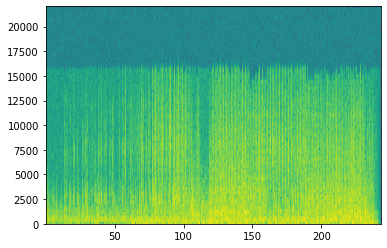

In [4]:
### get all audio files and create spectrogram for each track
Spectrograms = {'The Beatles': {}}
for filename in Path('Test-Audiofiles/The Beatles').glob('**/wav/*.wav'):
    
    path, track = os.path.split(filename)
    path, wav = os.path.split(path)
    path, album = os.path.split(path)
    
    track_no = re.search('([0-9].).',track).group(1)
    
    ### read wav and create spectogram
    sample_rate, samples = wavfile.read(filename)
    powerSpectrum, frequencies, times, imageAxis = plt.specgram(samples, Fs=sample_rate)
    
    if (album not in Spectrograms['The Beatles']): 
        Spectrograms['The Beatles'][album] = {}
        
    Spectrograms['The Beatles'][album][track_no] = {'powerSpectrum' : powerSpectrum, 
                                                    'frequencies' : frequencies, 
                                                    'times' : times}

<h3>Data preprocessing, convert data into input that I can feed in the neural network</h3>
<br>
<ol>
    <li> For training we should have all anotations, together with their spectrograms'
    <li> For testing all the spectrograms of the test dataset
</ol>
<br>
<b>Shape of the final training data</b>
<ul>
    <li>X_train, Y_train = [spectrograms], [annotations]
    <li>X_test = [spectrograms_test]
</ul>
<br>
<b>Steps to convert data from dictionaries into data that I can feed in the neural network</b>
<br>
Firstly, I'm thinking I have to create a vocabulary for the chords.<br>
Such as the <b>word2vec</b> representation we use on NLP, we will need in this project something similar.<br>
<b>Chord:</b><br>
C -> 0<br>
C#\Db -> 1<br>
D -> 2<br>
D#\Eb -> 3<br>
E -> 4<br>
F -> 5<br>
F#\Gb -> 6<br>
etc.<br>
<br>
<b>Mode:</b>
Minor Chord: 0<br>
Major Chord: 1<br>
<br>
<b>Sustained: </b>
1,2,3,4,5,6,7,8,9<br>

As it seems, the combinations can vary.<br>
So we can:
<ul>
    <li>try an encoding(hashing) for each chord, and when we stumble upon each chord we hash it to a unique combination that goes into a vector.</li>
    <li>we can iterate all train data, and for each chord we see, create a "slot" in our dictionary. So we have a dictionary with all the chords that appear on the dataset. That way we can work with a <b>one hot</b> representation.</li>
 </ul>

In [5]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  68


For one album we have 68 Chords, so our vectors are going to be <b>one hot vectors</b> of 68 size. (67 zeros and 1 one)<br>
Create one hot encodings of the chords, with <b>pandas Series + get_dummies</b><br>
<h4>One Hot Encodings</h4>
<br>
With <b>pandas</b>:

In [5]:
num_chords = len(Chords)
s = pd.Series(Chords)
OneHotEncodings = pd.get_dummies(s)

With <b>Sklearn</b>:<br>
<i>(which provides us with inverse transformation, for the results.)</i>

In [6]:
encoder = OneHotEncoder()
encoder.fit(np.array(pd.Series(Chords)).reshape(-1,1))

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

<h3>Indexing chords with timestamps</h3>
<br>
<center>
<img src="images/Vector_flow.jpg" width="900">
<caption><center> **Figure 1**: Data Processing.</center></caption>
</center>

Now we have to align the <b>timing of the chords</b> with the <b>times array</b><br>
To achieve that lets try to convert the timing - chords data of the .lab files in the same representation as the spectrograms data.<br>
We will keep the same timeline (times), and using the timing<br>
<b><font color='red'>Warning</font>: This is computational expensive for the cpu. If you have it ready, you can load it below with pickle.</b><br> 

In [7]:
chords2vec = {}
for album in Spectrograms['The Beatles'].keys():
    chords2vec[album] = {}
    for track_no in Spectrograms['The Beatles'][album].keys():
        times = Spectrograms['The Beatles'][album][track_no]['times']
        df_rows = Chordlab['The Beatles'][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab['The Beatles'][album][track_no])
        vector = np.empty((len(Chords),))
        row = next(df_rows)
        for timestamp in times:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            vector = np.column_stack((vector, encoder.transform([[row[3]]]).toarray()[0]))        
        chords2vec[album][track_no] = vector
        print ('track ', track_no, ' completed')

track  03  completed
track  07  completed
track  10  completed
track  12  completed
track  08  completed
track  01  completed
track  04  completed
track  11  completed
track  02  completed
track  05  completed
track  09  completed
track  06  completed


Now we have our 4D data ready in a dictionary to go into our model for training.<br>
3 dimensions (times, frequencies, power) will go as X_train and chords2vec will go as Y_train<br><br>

In [382]:
np.shape(Spectrograms['The Beatles']['12_-_Let_It_Be']['04']['powerSpectrum'])

(129, 50255)

Take care fo the one extra row in the beggining of the array

In [10]:
print (chords2vec['12_-_Let_It_Be']['03'].shape)

(68, 78632)


In [9]:
for track_no in chords2vec['12_-_Let_It_Be'].keys():
    chords2vec['12_-_Let_It_Be'][track_no] = np.delete(chords2vec['12_-_Let_It_Be'][track_no],0,1)

<b>Store - Load Data with pickle</b>

In [11]:
### STORE
import pickle

with open('let_it_Be.pickle', 'wb') as handle:
    pickle.dump(chords2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
### LOAD
import pickle

with open('let_it_Be.pickle', 'rb') as handle:
    chords2vec = pickle.load(handle)

In this article the following is stated.<br>
https://tm3.ghost.io/2018/09/05/building-lstms-for-time-series-forecasting/<br>
<i>"Instead of one sequence of 1870, you could have many sequences of let's say 20. Your sequences should be overlapping windows `[0-20], [1-21], [2-22]`, etc, so your final shape would be something like `(1850, 20, 14)`.Same process for your test data. Break into subsequences of the same length as training. You will have to play around with finding what a good subsequence length is. It is extremely important to have many different ways of slicing your data. If you train on just one super long sequence it will probably not learn anything interesting."</i>

<h3>Train/Test Data Initialization</h3>
<br>
<center>
<img src="./images/Starting_Vecs.jpg" width="900">
<caption><center> **Figure 1**: Data Processing.</center></caption>
</center>

<h4>1. Constructing numpy arrays</h4>

In [12]:
x_initial_train = np.zeros((1,129))
y_initial_train = np.zeros((1,len(Chords)))
test_track_no = '07'
for track_no in chords2vec['12_-_Let_It_Be'].keys():
    if track_no != '07':
        y_initial_train = np.append(y_initial_train, chords2vec['12_-_Let_It_Be'][track_no].T, axis = 0)
        x_initial_train = np.append(x_initial_train, Spectrograms['The Beatles']['12_-_Let_It_Be'][track_no]['powerSpectrum'].T, axis = 0)

y_initial_test = chords2vec['12_-_Let_It_Be']['07'].T
x_initial_test = Spectrograms['The Beatles']['12_-_Let_It_Be']['07']['powerSpectrum'].T

print (x_initial_train.shape, y_initial_train.shape)

(713717, 129) (713717, 68)


<h4>2. Normalization</h4>

In [13]:
scaler = StandardScaler()
# fit scaler on training dataset
scaler.fit(x_initial_train)
# transform training dataset
x_initial_train = scaler.transform(x_initial_train)

# fit scaler on training dataset
scaler.fit(x_initial_test)
# transform training dataset
x_initial_test = scaler.transform(x_initial_test)

# keras normalization
# x_initial_train = keras.utils.normalize(x_initial_train, axis = 0, order = 1)

<h4>3. Slicing in batches of timeseries and for the LSTM</h4>

In [14]:
# Slicing

# Find the chunk size
chunk_size = 1000
mod = x_initial_train.shape[1] // chunk_size + 1 #1.000 is the number of timestemps in each batch
x_train = np.zeros((1,1000,129)) #129 num of frequencies
y_train = np.zeros((1,1000,len(Chords)))

timestep = chunk_size
while timestep < x_initial_train.shape[0] :
    batch_x = np.resize(x_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size, 129)) #129 num of frequencies
    batch_y = np.resize(y_initial_train[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
    
    x_train = np.append(x_train, batch_x, axis = 0)
    y_train = np.append(y_train, batch_y, axis = 0)
    timestep += chunk_size
    
print (x_train.shape)
print (y_train.shape)

#delete first line batch of array because its zeros

(714, 1000, 129)
(714, 1000, 68)


In [15]:
x_test = np.zeros((1,1000,129)) #129 num of frequencies
y_test = np.zeros((1,1000,len(Chords)))

timestep = chunk_size
while timestep < x_initial_test.shape[0] :
    batch_x = np.resize(x_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size, 129)) #129 num of frequencies
    batch_y = np.resize(y_initial_test[timestep:timestep+chunk_size,:], (1, chunk_size,len(Chords)))
    
    x_test = np.append(x_test, batch_x, axis = 0)
    y_test = np.append(y_test, batch_y, axis = 0)
    timestep += chunk_size
    
print (x_test.shape)
print (y_test.shape)

#delete first line batch of array because its zeros

(14, 1000, 129)
(14, 1000, 68)


Delete the first row from every array because of the append, which left it all zeros.

In [16]:
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

print(x_train.shape)
print(y_train.shape)

(713, 1000, 129)
(713, 1000, 68)


<h3>TensorFlow model</h3>

Let's define first an RNN with tensorflow<br>
- Layers = dimensionality of the output space
- input shape = for every time step the feature shape
- Dense output shape is the chord num

In [401]:
def RNN(chords_num, frequencies_num, batch_size):
    
    model = tf.keras.models.Sequential()
    
    model.add(keras.layers.LSTM(frequencies_num, return_sequences = 'True'))
    model.add(keras.layers.LSTM(frequencies_num, return_sequences='True', activation='sigmoid'))
    model.add(keras.layers.Dense(chords_num, activation='softmax'))
    return model

In [402]:
epochs = 20

model = RNN(len(Chords), 129, chunk_size)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


# train
model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), verbose=0)

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               multiple                  133644    
_________________________________________________________________
lstm_53 (LSTM)               multiple                  133644    
_________________________________________________________________
dense_40 (Dense)             multiple                  8840      
Total params: 276,128
Trainable params: 276,128
Non-trainable params: 0
_________________________________________________________________


In [403]:
# evaluate on test set
scores = model.evaluate(x_test, y_test, verbose=0)
print("Final test loss and accuracy :", scores)

Final test loss and accuracy : [2.3226470947265625, 0.323]


<h3>Transform predictions into Chords</h3>
<br>
Get the resulting one hot encodings, map to the appropriate chords and write the result<br>

In [404]:
predictions = model.predict(x_test, use_multiprocessing=True)

In [405]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles']['12_-_Let_It_Be'][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        estimated_chord_list.append(encoder.inverse_transform([chord]).reshape(1,)[0])
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
df_predictions

,Estimated Chords
0,D
1,G
2,N
3,N
4,N
...,...
12995,N
12996,N
12997,N
12998,N
